In [1]:
%run PBM.ipynb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression

1.0


# Data import

In [2]:
df = pd.read_csv('particle_size.csv')
data = df.to_numpy()
size= data[:,0]
V = data[:,1:]/100
N = np.empty((61,6))
df2 = pd.read_csv('lognormal.csv')
data2 = df2.to_numpy()
mu = data2[0:4,-1]
sigma = data2[4:,-1]
T = np.array([0.,44.,88.,154.,330.,551.])

## Particle size
Mean particle size of miroflocs, primary particles, colloidal substances are decreasing as sonication time increases. Simple linear regression was adopted for mean particle size reduction.

In [212]:
t = T.reshape((-1,1))[1:]

In [216]:
mm = LinearRegression().fit(t, mu[1,1:])
pm = LinearRegression().fit(t, mu[2,1:])
cm = LinearRegression().fit(t, mu[3,1:])

In [217]:
def mu_micro(T):
    return mm.predict(T)
def mu_primary(T):
    return pm.predict(T)
def mu_colloidal(T):
    return cm.predict(T)

In [193]:
ynew = model.predict(x)

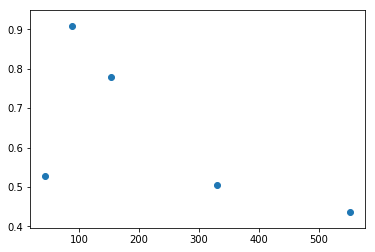

In [224]:
plt.scatter(T,sigma[3])

## Data interpolation
Since PBM has limitation on selection of particle size such as $l_{i+1}=2^{1/3}l_i$, size from the instrument should be interpolated to the size suitable to PBM. Cubic spline was adopted for the interpolation.

In [4]:
n = 41
L = np.empty(n)
L[0] = size[0]
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)

In [6]:
Vcs = np.empty((n,6))
for i in range(6):
    Vcs[:,i] = CubicSpline(size,V[:,i])(L)

# Convert volume to number
Simple relation between volume and number
\begin{equation}
V_i=N_i\times l_i^3
\end{equation}
was assumed.

In [7]:
N = np.empty((n,6))
for i in range(6):
    N[:,i] = np.divide(Vcs[:,i],L**3)

In [8]:
N0 = N[:,0]
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0 = np.append(N0,[m00,m10,m20,m30])

## Breakage function by log normal distribution

In [9]:
# microfloc
b1 = 1.0
# primary particle
b2 = 0.0
# colloidal substances
b3 = 1.0-b1-b2
def breakfunc(x,l):
    bf=b1*lognorm_b(x,l,mu[1],sigma[1])+b2*lognorm_b(x,l,mu[2],sigma[2])+b3*lognorm_b(x,l,mu[3],sigma[3])
    return bf

## Selection function
\begin{equation}
S(l)=S_0l^p
\end{equation}

In [10]:
S0 = 1e-4
p = 3
def selectionfunc(l):
    return S0*l**p

In [11]:
bmat = breakage_mat(selectionfunc,breakfunc,L,n)
Svec = selection_rate(selectionfunc,breakfunc,L,n,bmat)

calculating breakage matrix


KeyboardInterrupt: 

In [240]:
def dydx(t,y):
    return breakage(y,bmat,Svec)

In [260]:
sol = solve_ivp(dydx,[T[0],T[-1]],Y0,method='Radau',t_eval=T)
N = sol.y[0:-4,:]
M = sol.y[-4:,:]
V= np.empty(np.shape(N))
for i in range(6):
    V[:,i] = np.multiply(N[:,i],L**3)

(2, 0)

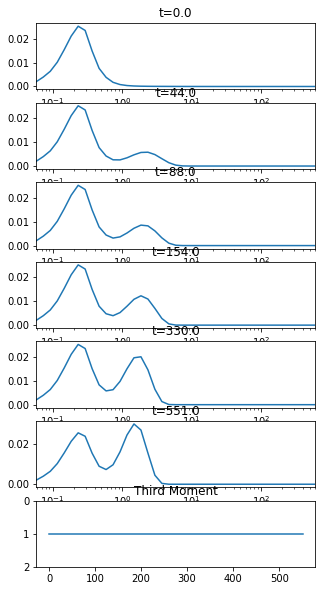

In [261]:
rows = len(T)
plt.close('all')
fig, axes = plt.subplots(rows+1,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))
M_norm = np.empty(np.shape(M))
for i in range(4):
    M_norm[i,:] = M[i,:]/M[i,0]
axes[rows].plot(T,M_norm[-1,:])
axes[rows].title.set_text('Third Moment')
axes[rows].set_ylim([2,0])

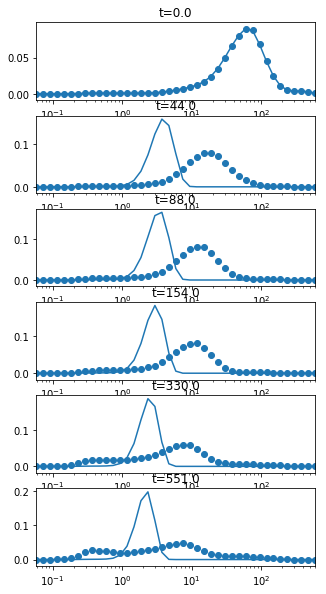

In [262]:
fig, axes = plt.subplots(rows,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,V[:,i])
    axes[i].scatter(L,Vcs[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))

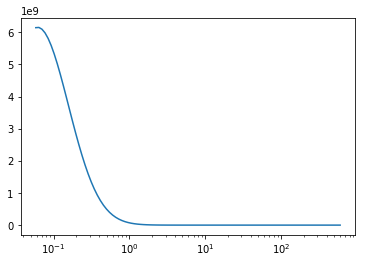

In [271]:
xx = np.logspace(np.log10(L[0]),np.log10(L[-1]),100)
plt.plot(xx,lognorm_b(xx,L[-1],mu[2],sigma[2]))
plt.xscale('log')

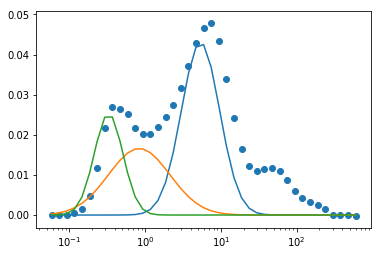

In [295]:
plt.plot(L,lnpdf(L,mu[1],sigma[1])/2.5)
plt.plot(L,lnpdf(L,mu[2],sigma[2])/20)
plt.plot(L,lnpdf(L,mu[3],sigma[3])/100)
plt.scatter(L,Vcs[:,5])
plt.xscale('log')

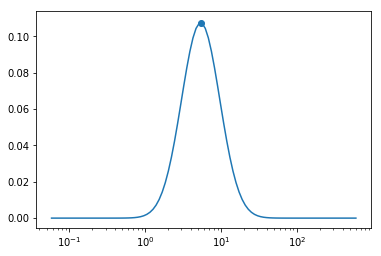

In [298]:
xx = np.logspace(np.log10(L[0]),np.log10(L[-1]),100)
pdf = lnpdf(xx,mu[1],sigma[1])
plt.plot(xx,pdf)
plt.xscale('log')
plt.scatter(np.exp(mu[1]-sigma[1]**2),max(pdf))

In [299]:
print(np.exp(mu[1]-sigma[1]**2))

5.387603389310469


In [81]:
def lnpdf(x,mu,sigma):
    return np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/(x*sigma*np.sqrt(2*np.pi))

def npdf(x,mu,sigma):
    return np.exp(-((x-mu)/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

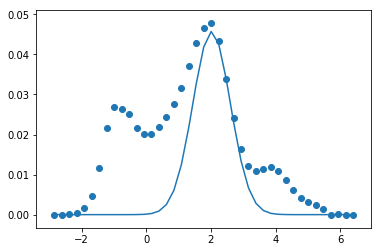

In [338]:
plt.plot(np.log(L),npdf(np.log(L),mu[1],sigma[1])/15)
plt.scatter(np.log(L),Vcs[:,5])

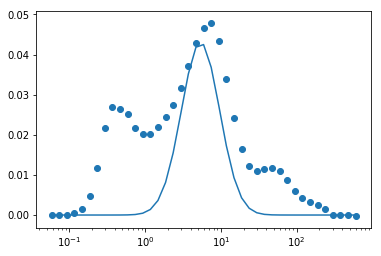

In [353]:
i=1
plt.plot(L,lnpdf(L,mu[i],sigma[i])/2.5)
plt.scatter(L,Vcs[:,5])
plt.xscale('log')

In [24]:
def muy(mux,sx):
    return np.exp(mux+sx**2/2)
def sy(mux,sx):
    return np.exp(2*mux+sx**2)*(np.exp(sx**2)-1)

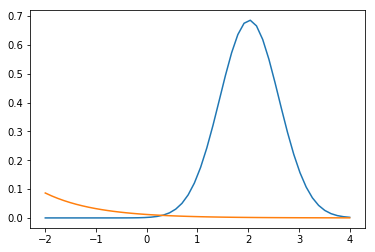

In [32]:
x = np.logspace(-2,4,base=np.e)
plt.plot(np.log(x),npdf(np.log(x),mu[1],sigma[1]))
plt.plot(np.log(x),lnpdf(x,muy(mu[1],sigma[1]),sy(mu[1],sigma[1])))

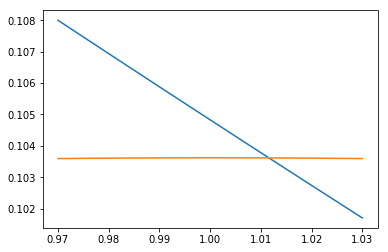

In [63]:
from scipy.stats import lognorm,norm
x = np.logspace(0.97,1.03,base=np.e)
sg = 1.4
mu = 1.0
plt.plot(np.log(x),lognorm.pdf(x, sg, scale=np.exp(mu)))
plt.plot(np.log(x),norm.pdf(np.log(x),mu,sg)/2.75)

In [91]:
mu = 1.0
sg = 1.4

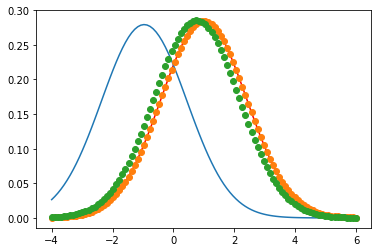

In [102]:
x = np.linspace(-4,6,100)
plt.plot(x,norm.pdf(x,mu,sg),'r')
plt.plot(x,lognorm.pdf(np.exp(x),sg,scale=np.exp(mu)))
plt.plot(x,npdf(x,mu,sg),'o')
plt.plot(x,lnpdf(np.exp(x),np.exp(mu),sg)*5.7,'o')

In [3]:
x

array([ 0.36787944,  0.40740024,  0.45116671,  0.49963495,  0.55331007,
        0.61275143,  0.67857851,  0.75147729,  0.8322075 ,  0.92161045,
        1.02061783,  1.13026145,  1.25168394,  1.38615068,  1.53506301,
        1.69997279,  1.88259861,  2.08484368,  2.30881566,  2.55684867,
        2.83152752,  3.13571476,  3.47258044,  3.84563514,  4.25876662,
        4.71628026,  5.22294398,  5.78403792,  6.40540943,  7.09353406,
        7.855583  ,  8.69949785,  9.63407336, 10.66904906, 11.81521083,
       13.08450324, 14.49015405, 16.04681206, 17.77069977, 19.67978244,
       21.79395533, 24.13525101, 26.72806898, 29.59942993, 32.77925738,
       36.30068947, 40.20042433, 44.51910253, 49.30173059, 54.59815003])

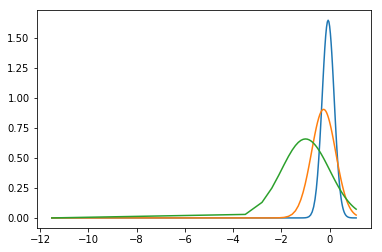

In [323]:
xx = np.linspace(1e-5,3,100)
plt.plot(np.log(xx),lnpdf(xx,0,0.25))
plt.plot(np.log(xx),lnpdf(xx,0,0.5))
plt.plot(np.log(xx),lnpdf(xx,0,1))

## Fitting lognormal data

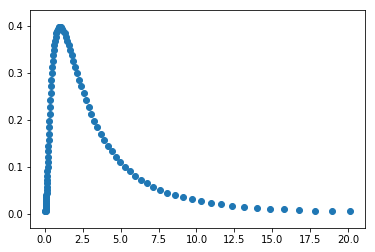

In [69]:
x = np.linspace(-3,3,100)
ex = np.exp(x)
y = norm.pdf(x,0,1)
plt.scatter(ex,y)

In [73]:
sample_dist = lognorm.pdf(x, 3, loc=0, scale=np.exp(10))

In [82]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(lnpdf,ex,y)

In [83]:
popt

array([0.53974053, 0.82547818])

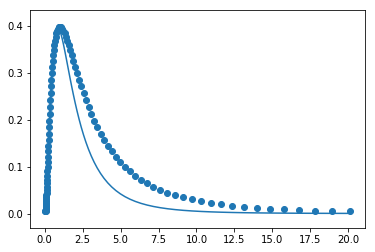

In [86]:
plt.scatter(ex,y)
plt.plot(ex,lnpdf(ex,*popt))

In [88]:
mean, var, skew, kurt = lognorm.stats(1, loc=0, scale=1, moments=’mv’)

SyntaxError: invalid character in identifier (<ipython-input-88-250a024b636f>, line 1)